# Tutorial de Word2Vec 

## En pocas palabras...

El supuesto subyacente de Word2Vec es que dos palabras que comparten contextos similares también comparten un significado similar y, por consiguiente, una representación vectorial similar del modelo. Por ejemplo: "perro", "perrito" y "cachorro" se utilizan a menudo en situaciones similares, con palabras cercanas similares como "bueno", "peludo" o "lindo", y según Word2Vec compartirán por lo tanto una representación vectorial similar.

A partir de esta hipótesis, Word2Vec puede utilizarse para averiguar las relaciones entre las palabras de un conjunto de datos, calcular la similitud entre ellas, o utilizar la representación vectorial de esas palabras como entrada para otras aplicaciones, como la clasificación o agrupación de textos.

## Ejercicio

En este Notebook vamos a desarrollar un Word2Vec utilizando la librería [Gensim](https://radimrehurek.com/gensim/models/word2vec.html) La cual es una de las más importantes en NLP.  Además de este módulo, para constuir un modelo robusto necesitamos: 
- Un corpus con suficiente contenido para crear un modelo 'inteligente'
- Limpiar y preporcesar el corpus.
- Suficiente RAM para entrenar el modelo (Es computancionalmente exigente) 

En este caso, vamos a crear un modelo específico para el show **Los Simpson's** 

Para poder ejecutar el Notebook recuerda instalar las dependencias de `./requirements.txt`


In [6]:
import re  # Procesamiento de Texto
import pandas as pd  
from time import time  # Medir tiempo de ejecucion
import multiprocessing
import logging  # Sacar logs del modelo

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import defaultdict  
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
import gensim.downloader as api

import spacy  # Procesamiento NLP


# Config Logs
logging.basicConfig(
    format="%(levelname)s - %(asctime)s: %(message)s", 
    datefmt= '%H:%M:%S', 
    level=logging.INFO
    )
# Configuramos estilo de arte de los plots.
sns.set_style("darkgrid")


In [8]:
# DATA DIR 
url = '../DATA/simpson_dataset.csv'
# cargamos datos 
df = pd.read_csv(url)
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [9]:
# datos nulos 
# Hay bastantes nulos que no nos van a servir para este proyecto
# los podemos eliminar directamente 
df.isnull().sum() # cantidad de nulos por columna

raw_character_text    17814
spoken_words          26459
dtype: int64

In [10]:
df = df.dropna().reset_index(drop=True) # eliminamos nulos 

# Limpieza del texto

Descargarse model de spacy english (o cualquier idioma): 
```python -m spacy download en_core_web_sm```

In [93]:
# !python -m spacy download en_core_web_sm

In [94]:
nlp = spacy.load(
  'en_core_web_sm',  # Capaz sea necesario descargar modelo de Spacy English.
  disable=['ner', 'parser']  # desactivamos modelos por facilidad de procesamiento
) 

def cleaning(doc) -> str:
  """
  Lemmatiza y elimina stopwords
  Necesitamos un doc como lo describe spacy
  :param doc: DOC según lo describe Spacy. 
  :return: Una cadena de texto. 
  """
  txt = [
     token.lemma_ for token in doc if not token.is_stop
  ]
  # Word2Vec usa el contexto para entender la reperesentacion de la palabra
  # Si la oracion es corta, no va a aprender mucho
  if len(txt) > 2:
      return ' '.join(txt)
  
# Reemplazamos todo lo que no sea alphanum por espacio
brief_cleaning = (
  re.sub(r"[^A-Za-z']+", 
  ' ', 
  str(row)).lower().strip() for row in df['spoken_words']  # por cada fila en df.
)

In [95]:
# Usamos el método Pipe de Spacy para procesar con mayor velocidad
t = time() # Calculamos tiempo

txt = [
    cleaning(doc) for doc in nlp.pipe(
        brief_cleaning, # función que def antes
        batch_size=5000, 
        n_process=-1 # usamos todos los cores
    )
]
# medimos tiempo de ejecución 
t_ = round((time() - t) / 60, 2) # Tiempo de ejecucion en mins
print(f'Tiempo de ejecución: {t_} mins')

Tiempo de ejecución: 0.6 mins


In [96]:
# Eliminamos duplicados o nulos si se han generado.
clean_txt = set(txt) # eliminamos duplicados 
clean_txt = [tx for tx in clean_txt if tx] # eliminamos nuevos nulos que se han creado

In [97]:
clean_txt[:4] # mostramos 'cabecera'

['woo hoo little boy',
 "like flander ' house",
 'read get gayer',
 'right underwater speaker amazing']

## Phraser (N gramas)

En NLP, nos interesa mantener el contexto alrededor de una palabra. Por ello, es útil también unificar palabras como un token único. Por ejemplo, nos intersa que el término "Big Data" sea considerado como un token único, así, cuando aparezcan juntas, sean consideradas bajo el mismo contexto. Es decir, pasaríamos de tener dos tokens: "Big" y "Data" a un único token: "big_data". 

In [98]:
# Phraser une palabras que usualmente están juntas,
# Por ejemplo Big Data -> big_data
sentences  = [row.split() for row in clean_txt if row]
phrases = Phrases(sentences, min_count=10, progress_per=10000)
bigram = Phraser(phrases)
ngram_sentences = bigram[sentences] 
# Vemos el vocabulario que hemos creado 
# Sanity check 
word_freq = defaultdict(int)
for sent in ngram_sentences:
    for i in sent:
        word_freq[i] += 1
print(f'El corpus tiene {len(word_freq)} palabras') 



INFO - 19:26:17: collecting all words and their counts
INFO - 19:26:17: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 19:26:17: PROGRESS: at sentence #10000, processed 62769 words and 55166 word types
INFO - 19:26:18: PROGRESS: at sentence #20000, processed 125617 words and 99378 word types
INFO - 19:26:18: PROGRESS: at sentence #30000, processed 188005 words and 139253 word types
INFO - 19:26:18: PROGRESS: at sentence #40000, processed 249772 words and 176261 word types
INFO - 19:26:18: PROGRESS: at sentence #50000, processed 311896 words and 211893 word types
INFO - 19:26:18: PROGRESS: at sentence #60000, processed 375204 words and 246785 word types
INFO - 19:26:18: PROGRESS: at sentence #70000, processed 437874 words and 279685 word types
INFO - 19:26:18: PROGRESS: at sentence #80000, processed 500825 words and 311577 word types
INFO - 19:26:18: collected 329452 token types (unigram + bigrams) from a corpus of 536719 words and 85776 sentences
INFO - 19:26:18: m

El corpus tiene 30076 palabras


In [99]:
# Miramos las palabras más comunes 
sorted(word_freq, key=word_freq.get, reverse=True)[:10]


['oh', 'like', 'know', 'get', 'think', 'come', 'hey', 'right', 'look', 'want']

In [100]:
sorted(
    {w: v for w,v in word_freq.items() if "_" in w},
    key=word_freq.get,
    reverse=True
)[:10]

['go_to',
 'get_to',
 'mr_burn',
 'homer_simpson',
 'oh_god',
 'wait_minute',
 'mr_simpson',
 'bart_simpson',
 'woo_hoo',
 'sound_like']

## Entrenamos nuestro Word2Vec.

Una vez ejecutado el preprocesamiento, estamos listos para crear nuestro modelo de lenguaje. 

In [101]:

cores = multiprocessing.cpu_count() # Cuenta el num de cores disponibles
#  The model (see Gensim's Word2Vec for more info )
w2v_model = Word2Vec(
    min_count=10,  # Num Mínimo de apariciones
    window=2,
    sample=6e-5, 
    alpha=0.03, 
    min_alpha=0.001, 
    negative=20,       
    workers=cores-1   # A toda maquina
)
#  Construimos el vocablo para gensim
w2v_model.build_vocab(
    ngram_sentences, progress_per=10000
)

#  Entrenamos el modelo (Toma unos minutos)

w2v_model.train(
    ngram_sentences,
    total_examples=w2v_model.corpus_count, 
    epochs=20, # Mientras más epochs, más iteraciones de entrenamiento.
    report_delay=1   
)

INFO - 19:26:29: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.03>', 'datetime': '2023-12-02T19:26:29.190902', 'gensim': '4.3.2', 'python': '3.10.0 (default, Mar  3 2022, 03:54:28) [Clang 12.0.0 ]', 'platform': 'macOS-13.6.2-arm64-arm-64bit', 'event': 'created'}
INFO - 19:26:29: collecting all words and their counts
INFO - 19:26:29: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:26:29: PROGRESS: at sentence #10000, processed 60270 words, keeping 10699 word types
INFO - 19:26:29: PROGRESS: at sentence #20000, processed 120703 words, keeping 15259 word types
INFO - 19:26:29: PROGRESS: at sentence #30000, processed 180599 words, keeping 18605 word types
INFO - 19:26:29: PROGRESS: at sentence #40000, processed 239939 words, keeping 21346 word types
INFO - 19:26:29: PROGRESS: at sentence #50000, processed 299658 words, keeping 23727 word types
INFO - 19:26:29: PROGRESS: at sentence #60000, processed 360538 words, keeping 25870 w

(4644698, 10315540)

## Ahora con el modelo entrenado, podemos probar los resultados. 
Una de las claves del W2V es poder medir la similitud entre términos. Esto se hace mediante la famosa word mover distance, que es una variación de la distancia coseno entre los vectores de las palabras. 

Recuerda que en este caso, utilizamos los diálogos de los personajes, por lo que si buscamos lo más similar a "Homer", no vamos a obtener muchas de las tradicionales frases del personaje, ya que muy rara vez Homer se refirirá a sí mismo en tercera persona. Más bien, se obtiene las palabras que usualmente acompañan al nombre 'Homer'. 

In [106]:
# Palabra más similar a homero
w2v_model.wv.most_similar(positive=["simpson"])

[('mr_mrs', 0.9169911742210388),
 ('reverend', 0.90602046251297),
 ('bob', 0.9046222567558289),
 ('ghost', 0.9000343084335327),
 ('homer_j', 0.896385669708252),
 ('sideshow_bob', 0.8916834592819214),
 ('principal_skinner', 0.8900757431983948),
 ('visit', 0.8899433016777039),
 ('mrs_krabappel', 0.8890350461006165),
 ('obvious', 0.8881278038024902)]

In [109]:
w2v_model.wv.most_similar("barney")

[('something', 0.9218274354934692),
 ('wanna', 0.9208303689956665),
 ('lenny', 0.9199902415275574),
 ('lemme', 0.9094627499580383),
 ('drunk', 0.9078493118286133),
 ('moe', 0.9061301350593567),
 ('flaming', 0.9022751450538635),
 ('right', 0.8997672200202942),
 ('homer', 0.896900475025177),
 ('gee', 0.8966143131256104)]

In [110]:
w2v_model.wv.most_similar(positive=["marge"])


[('fault', 0.9604268670082092),
 ('sweetie', 0.954429566860199),
 ('sister', 0.9533219337463379),
 ('nervous', 0.9479940533638),
 ('spend_time', 0.9465503692626953),
 ('honey', 0.9451213479042053),
 ('make_feel', 0.9437217116355896),
 ('sure', 0.9430326819419861),
 ('want', 0.9429095387458801),
 ('upset', 0.9423529505729675)]

In [111]:
w2v_model.wv.most_similar(positive=["bart"])


[('lisa', 0.9528846740722656),
 ('mom_dad', 0.9499770402908325),
 ('spend_time', 0.9442782402038574),
 ('dad', 0.9437201619148254),
 ('feel_bad', 0.9374975562095642),
 ('advice', 0.9347502589225769),
 ('scared', 0.9332586526870728),
 ('admit', 0.9308210611343384),
 ('upset', 0.9295666813850403),
 ('grampa', 0.928840160369873)]

También podemos calcular la similitud entre dos términos. Por ejemplo, Moe y Tavern

In [112]:
w2v_model.wv.similarity("tavern", 'moe')


0.7550927

In [113]:
w2v_model.wv.similarity("barney", 'drunk')


0.90784925

In [114]:
w2v_model.wv.similarity('maggie', 'baby')


0.83840215

In [115]:
w2v_model.wv.similarity('homer', 'school')


0.5439161

Gensim también nos permite extraer el 'Outlier', o el valor atípico

In [116]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])


'milhouse'

In [122]:
w2v_model.wv.doesnt_match(["bart", "moe", "milhouse"])


'moe'

### Diferencia Análoga:

Esto se podria entender como 'ecuaciones' con los embeddings. Es decir, por ejemplo, tomamos el vector de Woman, le sumamos el de Bart y le restamos el de Man. 

También se interpreta como, qué palabra es para Woman lo que Bart es para Man. 
Veamos qué resulta...



In [123]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=1)

[('lisa', 0.9104328155517578)]

In [126]:
w2v_model.wv.most_similar(positive=["marge", 'wife'], negative=["woman"], topn=2)

[('homer', 0.9178188443183899), ('honey', 0.904956042766571)]

In [132]:
w2v_model.wv.most_similar(positive=["school", "bart"], topn=5)

[('principal_skinner', 0.9346218109130859),
 ('learn', 0.9302953481674194),
 ('parent', 0.9260503649711609),
 ('important', 0.9212028980255127),
 ('behavior', 0.9179633855819702)]

## Visualizaciones 

In [133]:
w2v_model.wv.__getitem__(["homer_simpson"])

array([[-0.11389033,  0.24377829,  0.27286592, -0.20551257, -0.06983221,
        -0.24988678, -0.23632713,  0.57904094, -0.1409881 , -0.05722684,
        -0.20133454, -0.41510764,  0.11822813,  0.26852927, -0.11143427,
        -0.35551378,  0.04550735,  0.08345523,  0.3056969 , -0.02326445,
         0.18117489,  0.17100583,  0.12015061,  0.24883722,  0.01587669,
         0.16172867,  0.08059417, -0.34027806, -0.44570944, -0.44239905,
        -0.32645047,  0.3249574 , -0.4912409 ,  0.15919042,  0.09960841,
        -0.21043733, -0.11521112,  0.08054486,  0.04434061, -0.43360153,
        -0.01251924, -0.32463107, -0.20254993,  0.11090814, -0.06772007,
        -0.2696082 , -0.12589312,  0.47057763,  0.18702574,  0.39580497,
        -0.03343199, -0.30440125, -0.5016868 , -0.16081636, -0.14617127,
         0.104417  ,  0.27788058, -0.21325971, -0.2549439 , -0.11439832,
        -0.22826578, -0.12291327, -0.5456108 ,  0.28052315,  0.23484255,
         0.11232995, -0.08437873, -0.12661907, -0.0

In [134]:
#  Plotting
def tsnescatterplot(model: Word2Vec, word: str, list_names: list):
    """ 
    Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    :param model: A gensim word2vec model. 
    :param word: Keyword to compare to the list_names
    :param list_names: A user defined set list of words to compare to the main word.
    :return: A plot
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 20 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={
                         's': 40,
                         'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(
            df["x"][line],
            df['y'][line],
            '  ' + df["words"][line].title(),
            horizontalalignment='left',
            verticalalignment='bottom', size='medium',
            color=df['color'][line],
            weight='normal'
            ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title(f't-SNE visualization for {word.title()}')
    plt.show();

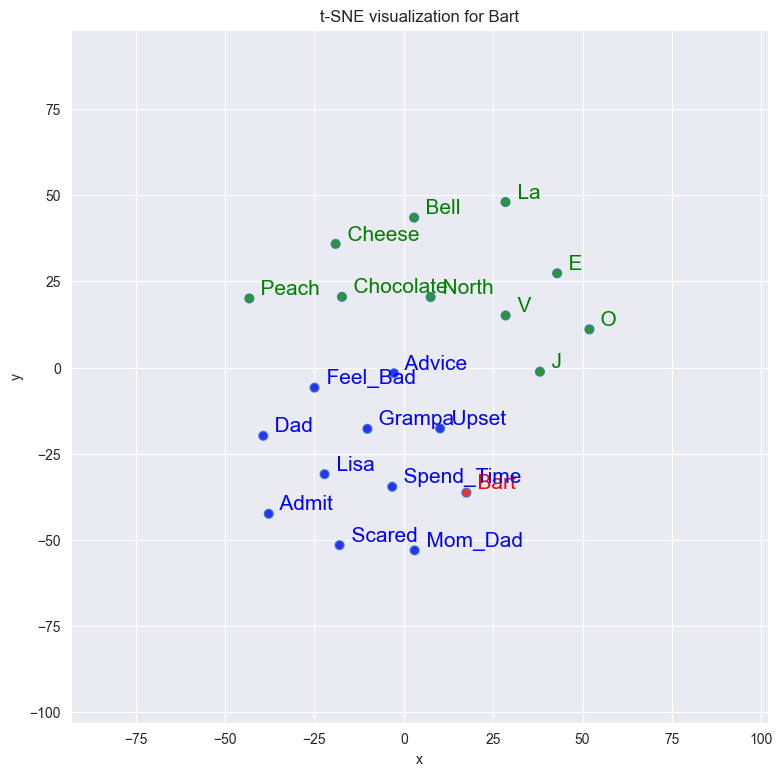

In [135]:
main_word = "bart"  # Palabra buscada
alternative_list =  [
    i[0] for i in w2v_model.wv.most_similar(
        negative=[main_word]  # Palabras negativas (opuestas)
        )
    ] 
# Llamamos a nuestra función
tsnescatterplot(w2v_model, main_word, alternative_list)

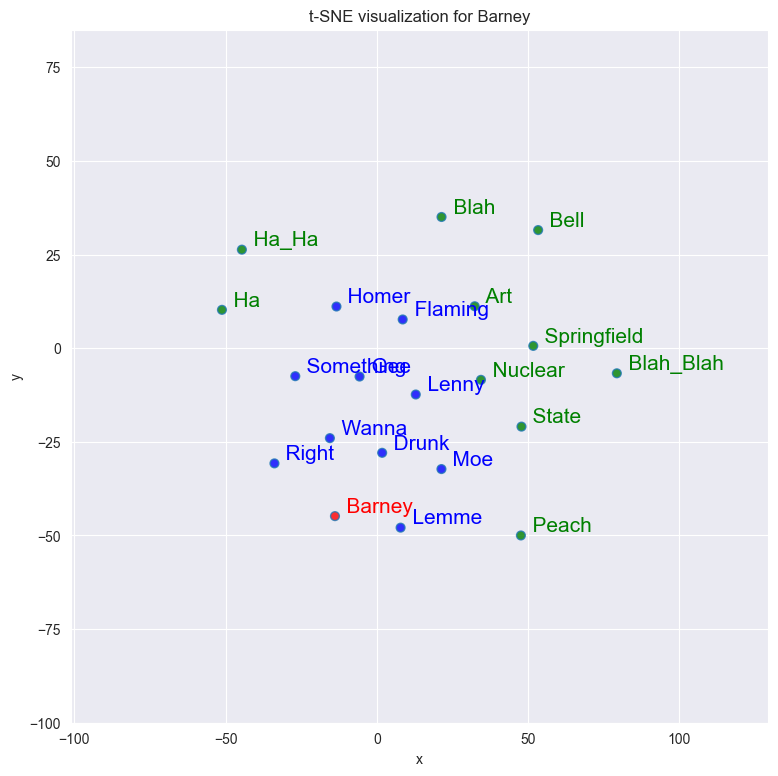

In [136]:
main_word = "barney"
alternative_list =  [
    i[0] for i in w2v_model.wv.most_similar(
        negative=[main_word]  # Palabras negativas (opuestas)
        )
    ] 
tsnescatterplot(w2v_model, main_word, alternative_list)

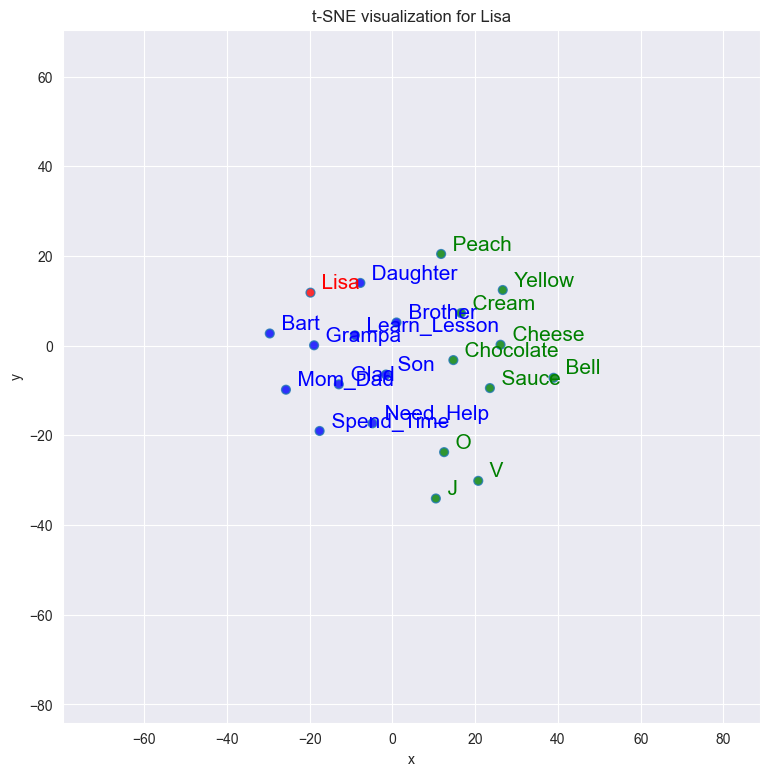

In [145]:
main_word = "lisa"  # Palabra buscada
alternative_list =  [
    i[0] for i in w2v_model.wv.most_similar(
        negative=[main_word]  # Palabras negativas (opuestas)
        )
    ] 
# Llamamos a nuestra función
tsnescatterplot(w2v_model, main_word, alternative_list)

# Cargar un modelo pre-entrenado.

No siempre será necesario entrenar un modelo propio y específico para el caso de uso. En internet y dentro de la misma librería Gensim se pueden encontrar varios modelos entrenados previamente con diferentes corpus y que tendrán mejor o peor desempeño dependiendo de la industria y caso de uso. Por ejemplo, se pueden encontrar modelos generalistas entrenados con artículos de Wikipedia, u otros más especializados con artículos médicos como los de [SciSpacy](https://allenai.github.io/scispacy/)

Esto nos permitirá aprovechar de las múltiples funcionalidades de un Embedding sin tener que pasar por la costosa fase de entrenamiento.

En Gensim podemos utilizar algunos de los modelos y corpus ya preparados de esta [lista](https://radimrehurek.com/gensim/auto_examples/howtos/run_downloader_api.html)


Para este caso cargaremos el famoso [Glove Wiki Gigaword (50)](https://nlp.stanford.edu/projects/glove/) que es otra aproximación de word embeddings. El Word2Vec toma los textos como datos de entrenamiento para una red neuronal. Los vectores resultantes captan si las palabras aparecen en contextos similares. GloVe se centra en las co-ocurrencias de palabras en todo el corpus. Sus vectores se relacionan con las probabilidades de que dos palabras aparezcan juntas. Sin embargo, a pesar de que su entrenamiento y marco teorico sean distitnos, en Gensim su uso es prácticamente igual. 

In [146]:
# Cargamos el modelo en memoria
model = api.load('glove-wiki-gigaword-50')

INFO - 19:34:42: Creating /Users/kdlx593/gensim-data


[==================================================] 100.0% 66.0/66.0MB downloaded


INFO - 19:37:58: glove-wiki-gigaword-50 downloaded
INFO - 19:37:58: loading projection weights from /Users/kdlx593/gensim-data/glove-wiki-gigaword-50/glove-wiki-gigaword-50.gz
INFO - 19:38:04: KeyedVectors lifecycle event {'msg': 'loaded (400000, 50) matrix of type float32 from /Users/kdlx593/gensim-data/glove-wiki-gigaword-50/glove-wiki-gigaword-50.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-12-02T19:38:04.760403', 'gensim': '4.3.2', 'python': '3.10.0 (default, Mar  3 2022, 03:54:28) [Clang 12.0.0 ]', 'platform': 'macOS-13.6.2-arm64-arm-64bit', 'event': 'load_word2vec_format'}


In [148]:
# Lo probamos :) 
model.most_similar(positive=["tree"])

[('trees', 0.8877023458480835),
 ('pine', 0.78980553150177),
 ('flower', 0.7542152404785156),
 ('oak', 0.7453587055206299),
 ('green', 0.7451863288879395),
 ('leaf', 0.7414467334747314),
 ('bark', 0.719155490398407),
 ('planted', 0.7050561308860779),
 ('cedar', 0.7033277153968811),
 ('garden', 0.7028762102127075)]

In [149]:
model.most_similar(positive=["queen"])

[('princess', 0.8515165448188782),
 ('lady', 0.8050608038902283),
 ('elizabeth', 0.7873042225837708),
 ('king', 0.7839043736457825),
 ('prince', 0.7821861505508423),
 ('coronation', 0.7692778706550598),
 ('consort', 0.7626097202301025),
 ('royal', 0.7442863583564758),
 ('crown', 0.7382649183273315),
 ('victoria', 0.728577196598053)]

Podemos ver que relaciona términos parecidos correctamente, pero,  ¿realmente entiende el contexto? Hagamos una prueba. En teoría, si yo tomo el vector de la palabra rey, le sumo el vector de la palabra mujer y le resto el vector de la palabra hombre, debería tener su contra-parte mujer, es decir, Reina. 
Lo probamos!

In [152]:
model.most_similar(positive=["king", "woman"], negative=["man"], topn=1)

[('queen', 0.8523604273796082)]

In [161]:
model.most_similar(positive=["paella", "italy"], negative=["spain"], topn=5)

[('lasagna', 0.717583179473877),
 ('risotto', 0.7148890495300293),
 ('lasagne', 0.6935400366783142),
 ('cassoulet', 0.6885650157928467),
 ('gnocchi', 0.6825464963912964)]